# Prevendo os Sobreviventes do Titanic

In [1]:
#Importando as Bibliotecas
# Algerbra Linear
import numpy as np 

# Processamento de Dados
import pandas as pd 

# Visualização de Dados
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

# Algoritimos de Modelos de Machine Learning
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

C:\Users\Glauber Oliveira\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Pegando os Dados
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")

In [3]:
#Exploraçao Inicial dos Dados
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


### O conjunto de treinamento tem 891 exemplos e 11 recursos + a variável de destino (sobreviveu). 
### 2 dos recursos são floats, 5 são inteiros e 5 são objetos. Abaixo listei os recursos com uma breve descrição:

In [6]:
#survival:    Survival 
#PassengerId: Unique Id of a passenger. 
#pclass:    Ticket class     
#sex:    Sex     
#Age:    Age in years     
#sibsp:    # of siblings / spouses aboard the Titanic     
#parch:    # of parents / children aboard the Titanic     
#ticket:    Ticket number     
#fare:    Passenger fare     
#cabin:    Cabin number     
#embarked:    Port of Embarkation
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Acima podemos ver que 38% dos dados da tabela de treinos sobreviveram ao Titanic. Também podemos ver que as idades dos passageiros variam de 0,4 a 80 anos. Além disso, já podemos detectar alguns recursos que contêm valores ausentes, como o recurso "Idade" e vamos precisar trabalhar nisso.

In [7]:
train_df.head(8)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S


### Da tabela acima, podemos notar algumas coisas. Em primeiro lugar, precisamos converter algumas features em dados numéricos posgterioremente, para que os algoritmos de aprendizado de máquina possam processá-los. Além disso, podemos ver que os recursos têm intervalos amplamente diferentes, que precisaremos converter em aproximadamente da mesma escala. Também podemos detectar mais alguns recursos, que contêm valores ausentes (NaN = não númérico), que precisam ser tratados.

### Vamos dar uma olhada mais detalhada em quais dados estão realmente ausentes:

In [10]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent_1 = train_df.isnull().sum()/train_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])

missing_data.head(5)

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
Fare,0,0.0
Ticket,0,0.0


### O feature "Embarked" tem apenas dois valores ausentes, que podem ser facilmente preenchidos. Será muito mais complicado lidar com o recurso "Age", que tem 177 valores em falta. O recurso "Cabin" precisa de mais investigações, mas parece que podemos deixá-lo do conjunto de dados, já que 77% dele está faltando.

In [26]:
train_df.columns.values

array(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Embarked', 'relatives', 'not_alone', 'Deck'],
      dtype=object)

### Acima você pode ver as 11 features + a variável alvo (sobreviveu). Quais recursos podem contribuir para uma alta taxa de sobrevivência?

### Para mim, faria sentido se tudo, exceto "PassengerId", "Ticket" e "Name", fosse correlacionado com uma alta taxa de sobrevivência.

## 1. Age and Sex:

C:\Users\Glauber Oliveira\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


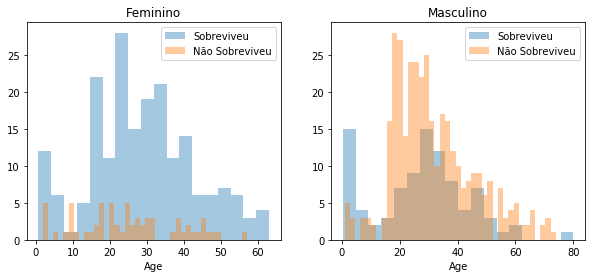

In [13]:
survived = 'Sobreviveu'
not_survived = 'Não Sobreviveu'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
women = train_df[train_df['Sex']=='female']
men = train_df[train_df['Sex']=='male']
ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False)
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Feminino')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False)
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False)
ax.legend()
_ = ax.set_title('Masculino')

### Você pode ver que os homens têm uma alta probabilidade de sobrevivência quando têm entre 18 e 30 anos, o que também é um pouco verdadeiro para as mulheres, mas não totalmente. Para as mulheres, as chances de sobrevivência são maiores entre 14 e 40 anos.

### Para os homens, a probabilidade de sobrevivência é muito baixa entre os 5 e os 18 anos, mas isso não é verdade para as mulheres. Outra coisa a notar é que os bebês também têm uma probabilidade um pouco maior de sobrevivência.

### Uma vez que parece haver certas idades, que aumentaram as chances de sobrevivência e porque eu quero que todos os recursos estejam mais ou menos na mesma escala, seria bem legal criar grupos etários mais tarde.

## 2. Embarked, Pclass and Sex:

C:\Users\Glauber Oliveira\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


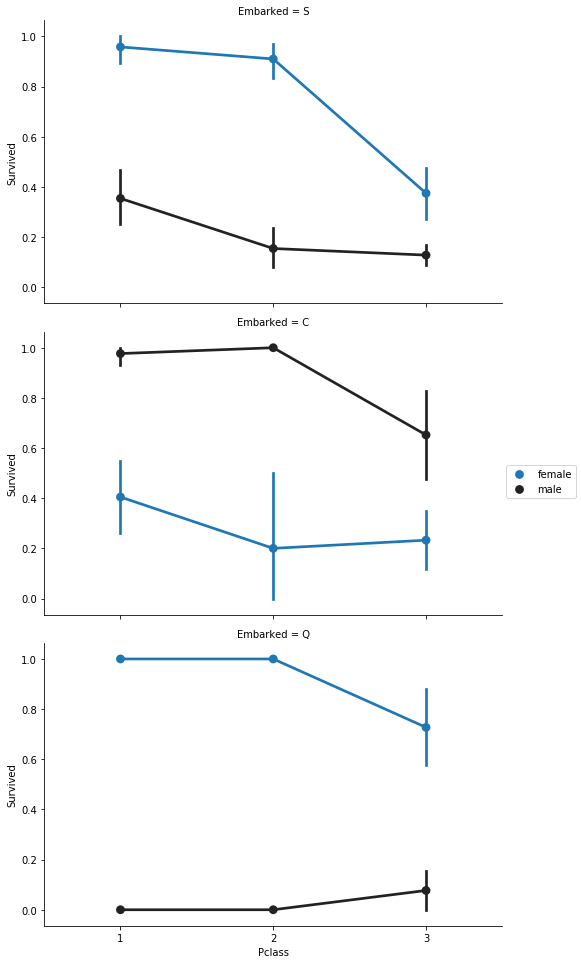

In [14]:
FacetGrid = sns.FacetGrid(train_df, row='Embarked', size=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette=None,  order=None, hue_order=None )
FacetGrid.add_legend()

### Local de Embarcação parece estar correlacionada com a sobrevivência, dependendo do sexo.

### As mulheres no porto Q e no porto S têm maior chance de sobrevivência. O inverso é verdadeiro, se estiverem na porta C. Os homens têm uma alta probabilidade de sobrevivência se estiverem na porta C, mas uma probabilidade baixa se estiverem na porta Q ou S.

### Pclass também parece estar correlacionado com a sobrevivência. Nós vamos gerar outro gráfico abaixo.

## 3. Pclass:

C:\Users\Glauber Oliveira\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


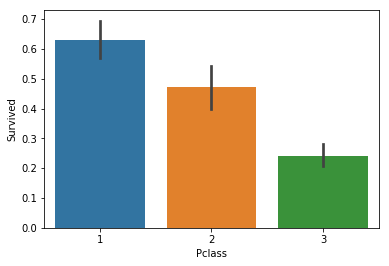

In [15]:
sns.barplot(x='Pclass', y='Survived', data=train_df)

### Aqui vemos claramente que a Pclass está contribuindo para a chance de sobrevivência de uma pessoa, especialmente se essa pessoa está na classe 1. Vamos criar outra plotagem de Pclass abaixo.

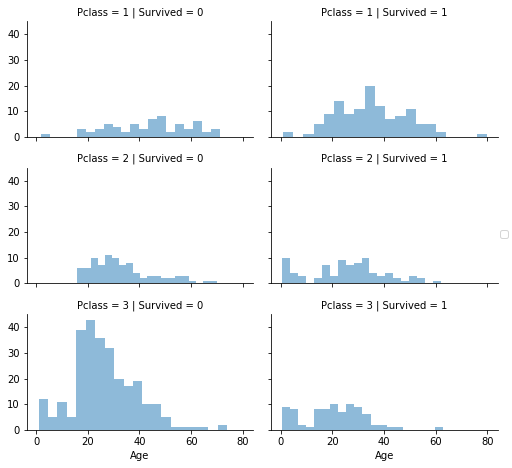

In [17]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

### O gráfico acima confirma nossa hipótese sobre a Pclass 1, mas também podemos identificar uma alta probabilidade de que uma pessoa na Pclass 3 não sobreviva.

## 4. SibSp and Parch:

### SibSp e Parch parece fazer mais sentido como uma característica combinada, que mostra o número total de parentes que uma pessoa tinha no Titanic. Vou criá-lo abaixo e também uma feature que informa se a pessoa não está sozinho.

In [18]:
data = [train_df, test_df]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)
train_df['not_alone'].value_counts()

1    537
0    354
Name: not_alone, dtype: int64

C:\Users\Glauber Oliveira\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


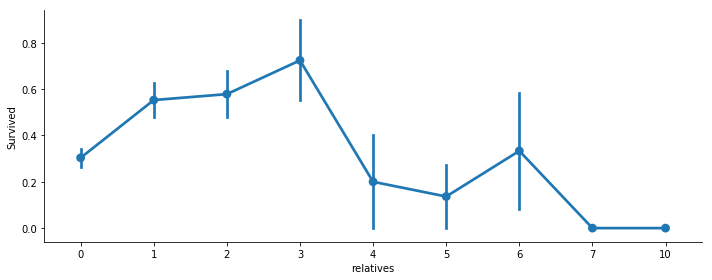

In [19]:
axes = sns.factorplot('relatives','Survived', 
                      data=train_df, aspect = 2.5, )

### Aqui podemos ver que você tinha uma alta probabilidade de sobrevivência com 1 a 3 parentes, mas um menor se você tivesse menos de 1 ou mais de 3 (exceto em alguns casos com 6 parentes).

## Processamento dos Dados

### Primeiro, vou remover ‘PassengerId’ do conjunto de dados de treino, porque isso não contribui para a probabilidade de sobrevivência de uma pessoa.

In [22]:
train_df = train_df.drop(['PassengerId'], axis=1)

KeyError: "['PassengerId'] not found in axis"

## Dados Vazios:

### Cabin:
#### Lembramos que temos que lidar com Cabin (687), Embarked (2) e Age (177). Primeiro, pensei, temos que excluir a variável "Cabin", mas depois encontramos algo interessante. Um número de cabine se parece com "C123" e a letra se refere ao Deck. Portanto, vamos extraí-los e criar uma nova feature que contenha o deck da pessoas. Depois, converteremos a feature em uma variável numérica. Os valores ausentes serão convertidos em zero. Na foto abaixo você pode ver os decks atuais do Titanic, variando de A a G.

In [25]:
import re
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [train_df, test_df]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)
# podemos agora remover a feature Cabin
train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)

In [28]:
train_df.columns.values

array(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Embarked', 'relatives', 'not_alone', 'Deck'],
      dtype=object)

## Idade
### Agora podemos resolver o problema com os valores ausentes da faixa etária. Vou criar um array que contém números aleatórios, que são calculados com base no valor médio de idade em relação ao desvio padrão e is_null.

In [29]:
data = [train_df, test_df]

for dataset in data:
    mean = train_df["Age"].mean()
    std = test_df["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = train_df["Age"].astype(int)
train_df["Age"].isnull().sum()

0

## Embarked 
### Como tem apenas dois valores ausentes, apenas os preencheremos com o mais comum.

In [30]:
train_df['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [31]:
common_value = 'S'
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

## Convertendo Features:

In [32]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
Survived     891 non-null int64
Pclass       891 non-null int64
Name         891 non-null object
Sex          891 non-null object
Age          891 non-null int32
SibSp        891 non-null int64
Parch        891 non-null int64
Ticket       891 non-null object
Fare         891 non-null float64
Embarked     891 non-null object
relatives    891 non-null int64
not_alone    891 non-null int32
Deck         891 non-null int32
dtypes: float64(1), int32(3), int64(5), object(4)
memory usage: 80.1+ KB


### Acima, você pode ver que "Fare" (Tarifa) é um float e temos que lidar com quatro características categóricas: Nome, Sexo, Bilhete e Embarcado. Vamos investigar e transformar um após o outro.

## Fare:
### Convertendo “Fare” de float para int64, usando a função “astype ()”, o pandas fornece:

In [33]:
data = [train_df, test_df]

for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

## Nome:
### Usaremos o recurso Nome para extrair os Títulos do Nome, para que possamos criar uma nova feature a partir disso.

In [34]:
data = [train_df, test_df]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # convert titles into numbers
    dataset['Title'] = dataset['Title'].map(titles)
    # filling NaN with 0, to get safe
    dataset['Title'] = dataset['Title'].fillna(0)
train_df = train_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)

In [35]:
train_df.columns.values

array(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Embarked', 'relatives', 'not_alone', 'Deck', 'Title'],
      dtype=object)

## Sexo:
### Convertendo a feature Sex em numérica

In [36]:
genders = {"male": 0, "female": 1}
data = [train_df, test_df]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

## Ticket

In [37]:
train_df['Ticket'].describe()


count        891
unique       681
top       347082
freq           7
Name: Ticket, dtype: object

### Como o atributo Ticket tem 681 tickets únicos, será um pouco complicado e até parece ser inútil convertê-los em categorias úteis. Então vamos remove-las do conjunto de dados.

In [38]:
train_df = train_df.drop(['Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)

In [39]:
train_df.columns.values

array(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'relatives', 'not_alone', 'Deck', 'Title'],
      dtype=object)

## Embarked:
### Convertendo a feature de enbarcação para uma feature numérica

In [40]:
ports = {"S": 0, "C": 1, "Q": 2}
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

## Criando novas Categorias:

## Vamos agora crias novas categorias com as seguintes features:

## 1: Idade
### Agora precisamos converter o recurso "age". Primeiro vamos convertê-lo de float em inteiro. Em seguida, criaremos a nova variável "AgeGroup", categorizando cada idade em um grupo. Observe que é importante prestar atenção em como você forma esses grupos, pois você não quer, por exemplo, que 80% dos seus dados caiam no grupo 1.

In [41]:
data = [train_df, test_df]
for dataset in data:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 6

# Vamos ver como ficou a distribuiçao 
train_df['Age'].value_counts()

4    164
6    155
5    143
3    135
2    125
1    101
0     68
Name: Age, dtype: int64

### Tarifa:
### Para o recurso "Tarifa", precisamos fazer o mesmo com o recurso "Idade". Mas isso não é fácil, porque se reduzirmos o intervalo dos valores de tarifa para algumas categorias igualmente grandes, 80% dos valores cairiam na primeira categoria. Felizmente, podemos usar a função “qcut ()”, que podemos usar para ver como podemos formar as categorias.

In [42]:
train_df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,relatives,not_alone,Deck,Title
0,0,3,0,2,1,0,7,0,1,0,8,1
1,1,1,1,5,1,0,71,1,1,0,3,3
2,1,3,1,3,0,0,7,0,0,1,8,2
3,1,1,1,5,1,0,53,0,1,0,3,3
4,0,3,0,5,0,0,8,0,0,1,8,1
5,0,3,0,4,0,0,8,2,0,1,8,1
6,0,1,0,6,0,0,51,0,0,1,5,1
7,0,3,0,0,3,1,21,0,4,0,8,4
8,1,3,1,3,0,2,11,0,2,0,8,3
9,1,2,1,1,1,0,30,1,1,0,8,3


In [43]:
data = [train_df, test_df]

for dataset in data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)

## Criando Novas Features
### Vamos adicionar basicamente duas novas features levando em consideração dois conjuntos de Features: 

## Idade x Classe

In [44]:
data = [train_df, test_df]
for dataset in data:
    dataset['Age_Class']= dataset['Age']* dataset['Pclass']

## Tarifa x Pessoa

In [45]:
for dataset in data:
    dataset['Fare_Per_Person'] = dataset['Fare']/(dataset['relatives']+1)
    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)

In [46]:
train_df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,relatives,not_alone,Deck,Title,Age_Class,Fare_Per_Person
0,0,3,0,2,1,0,0,0,1,0,8,1,6,0
1,1,1,1,5,1,0,3,1,1,0,3,3,5,1
2,1,3,1,3,0,0,0,0,0,1,8,2,9,0
3,1,1,1,5,1,0,3,0,1,0,3,3,5,1
4,0,3,0,5,0,0,1,0,0,1,8,1,15,1
5,0,3,0,4,0,0,1,2,0,1,8,1,12,1
6,0,1,0,6,0,0,3,0,0,1,5,1,6,3
7,0,3,0,0,3,1,2,0,4,0,8,4,0,0
8,1,3,1,3,0,2,1,0,2,0,8,3,9,0
9,1,2,1,1,1,0,2,1,1,0,8,3,2,1


## Construindo os Modelos de Machine Learning

### Agora vamos treinar vários modelos de Machine Learning e comparar seus resultados. Observe que, como o conjunto de dados não fornece rótulos para seu conjunto de testes, precisamos usar as previsões no conjunto de treinamento para comparar os algoritmos uns com os outros. Mais tarde, usaremos validação cruzada.

In [47]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()

## Stochastic Gradient Descent (SGD):

In [48]:
sgd = linear_model.SGDClassifier(max_iter=5, tol=None)
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)

sgd.score(X_train, Y_train)

acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)

## Random Forest:

In [49]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)

## Logistic Regression:

In [50]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, Y_train) * 100, 2)

## K Nearest Neighbor:

In [51]:
# KNN 
knn = KNeighborsClassifier(n_neighbors = 3) 
knn.fit(X_train, Y_train) 
Y_pred = knn.predict(X_test)  
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)

## Gaussian Naive Bayes:

In [52]:
gaussian = GaussianNB() 
gaussian.fit(X_train, Y_train)  
Y_pred = gaussian.predict(X_test)  
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)

## Rede Neural Perceptron:

In [53]:
perceptron = Perceptron(max_iter=5)
perceptron.fit(X_train, Y_train)

Y_pred = perceptron.predict(X_test)

acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)

## Linear Support Vector Machine:

In [54]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)

Y_pred = linear_svc.predict(X_test)

acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)

## Decision Tree

In [55]:
decision_tree = DecisionTreeClassifier() 
decision_tree.fit(X_train, Y_train)  
Y_pred = decision_tree.predict(X_test)  
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)

## Qual é o Melhor Modelo?

In [56]:
results = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 
              'Decision Tree'],
    'Score': [acc_linear_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_decision_tree]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df.head(9)

,Model
Score,
92.59,Random Forest
92.59,Decision Tree
88.22,KNN
81.71,Logistic Regression
81.37,Support Vector Machines
80.70,Perceptron
77.55,Naive Bayes
64.31,Stochastic Gradient Decent


### Como podemos ver, o classificador Random Forest ficou em primeiro lugar. 

## K-Fold Cross Validation:

### K-Fold Cross Validation divide aleatoriamente os dados de treinamento em K subconjuntos chamados dobras. Vamos imaginar que nós dividiríamos nossos dados em 4 dobras (K = 4). Nosso modelo seria treinado e avaliado 4 vezes, usando uma dobra diferente para avaliação toda vez, enquanto seria treinado nas 3 dobras restantes.

### O código abaixo executa a Validação Cruzada de Dobra em K em nosso modelo usando 10 dobras (K = 10). Portanto, gera uma matriz com 10 pontuações diferentes.

In [57]:
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rf, X_train, Y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.77777778 0.83333333 0.74157303 0.82022472 0.86516854 0.84269663
 0.78651685 0.79775281 0.84269663 0.86363636]
Mean: 0.8171376688230622
Standard Deviation: 0.038236194475868


#### Isso parece muito mais realista do que antes. Nosso modelo tem uma precisão média de 82% com um desvio padrão de 4%. O desvio padrão nos mostra quão precisas são as estimativas.

#### Isso significa, no nosso caso, que a precisão do nosso modelo pode diferir de + - 4%.

#### Acho que a precisão ainda é muito boa e, como o Random Forest é um modelo fácil de usar, tentaremos aumentar ainda mais o desempenho na seção a seguir.

## Features que mais importam

### Outra grande qualidade de Random Forest é que eles facilitam muito a medição da importância relativa de cada feature. O Sklearn mede a importância de uma feature observando o quanto os nós da árvore, que usam esse recurso, reduzem a impureza em média (em todas as árvores da floresta). Ele calcula essa pontuação automaticamente para cada recurso após o treinamento e dimensiona os resultados para que a soma de todas as importâncias seja igual a 1. Entraremos abaixo:

In [58]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(15)

,importance
feature,
Title,0.207
Sex,0.160
Age_Class,0.102
Deck,0.083
Pclass,0.076
Age,0.073
Fare,0.070
relatives,0.063
Embarked,0.050


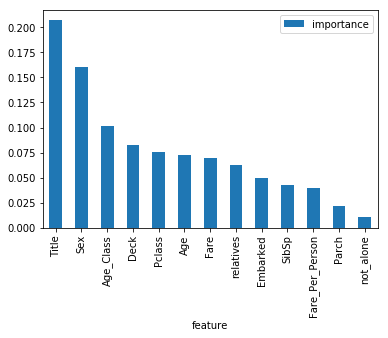

In [59]:
importances.plot.bar()

## Conclusão:
### not_alone e Parch não desempenham um papel significativo em nosso processo de previsão de classificadores no modelo do Random Forest. Por causa disso podemos descarta-los do conjunto de dados e treinar o classificador novamente. Também poderíamos remover mais ou menos recursos, mas isso exigiria uma investigação mais detalhada do efeito dos recursos em nosso modelo. Mas acho que é bom remover apenas o not_alone and Parch.

In [60]:
train_df  = train_df.drop("not_alone", axis=1)
test_df  = test_df.drop("not_alone", axis=1)

train_df  = train_df.drop("Parch", axis=1)
test_df  = test_df.drop("Parch", axis=1)

### Treinando novamente sem as features not_alone e Parch

In [61]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100, oob_score = True)
random_forest.fit(X_train, Y_train)
Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)

acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
print(round(acc_random_forest,2,), "%")

92.59 %


### Nosso modelo continuou tão bom quanto antes. Uma regra geral é que, quanto mais features você tiver, mais provável será que seu modelo sofra overfitting e vice-versa. Mas acho que nossos dados parecem bem por enquanto e não têm muitos recursos.

### Há também outra maneira de avaliar um classificador Random Forest, que é provavelmente muito mais preciso do que a pontuação que usamos antes. O que estou falando é das amostras "fora do saco" (out-of-bag - oob) para estimar a precisão da generalização. 

In [62]:
print("oob score:", round(random_forest.oob_score_, 4)*100, "%")

oob score: 80.47 %


### Agora podemos comerçar o Tunning do nosso Modelo

## Hiperparametrização de features

### Abaixo você pode ver o código do ajuste do hyperparamter para o critério de parâmetros, min_samples_leaf, min_samples_split e n_estimators. 
### ATENÇÃO PARA EXECUTAR O CÓDIGO ABAIXO, EXTREMAMENTE PESADO E LENTO, PODE TRAVAR SUA MAQUINA

In [63]:
param_grid = { "criterion" : ["gini", "entropy"], 
              "min_samples_leaf" : [1, 5, 10, 25, 50, 70], 
              "min_samples_split" : [2, 4, 10, 12, 16, 18, 25, 35], 
              "n_estimators": [100, 400, 700, 1000, 1500]}
from sklearn.model_selection import GridSearchCV, cross_val_score
rf = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1, n_jobs=-1)
clf = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1)
clf.fit(X_train, Y_train)
clf.bestparams

KeyboardInterrupt: 

### Eu coloquei este código em uma célula de remarcação e não em uma célula de código, porque leva muito tempo para executá-lo. Diretamente aqui em baixo coloquei as melhores indicações do Tunning.

In [ ]:
#criterion = "gini", 
#  min_samples_leaf = 1, 
#  min_samples_split = 10,   
#  n_estimators=100,

## Testando os Novos Parametros

In [64]:
# Random Forest
random_forest = RandomForestClassifier(criterion = "gini", 
                                       min_samples_leaf = 1, 
                                       min_samples_split = 10,   
                                       n_estimators=100, 
                                       max_features='auto', 
                                       oob_score=True, 
                                       random_state=1, 
                                       n_jobs=-1)

random_forest.fit(X_train, Y_train)
Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)

print("oob score:", round(random_forest.oob_score_, 4)*100, "%")

oob score: 84.17999999999999 %


### Agora que temos um modelo adequado, podemos começar a avaliar sua performace de maneira mais precisa. Anteriormente, usamos apenas a precisão e o Score OOB, que é apenas outra forma de precisão. O problema é que é mais complicado avaliar um modelo de classificação do que um modelo de regressão. Vamos falar sobre logo mais.

## Avaliação adicional

### Matriz de Confusão

In [66]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
predictions = cross_val_predict(random_forest, X_train, Y_train, cv=3)
confusion_matrix(Y_train, predictions)

array([[492,  57],
       [ 95, 247]], dtype=int64)

#### A primeira linha é sobre as predições não sobrevividas: 492 passageiros foram classificados corretamente como não sobrevividos (chamados de verdadeiros negativos) e 57 foram erroneamente classificados como não sobrevividos (falsos positivos).

#### A segunda linha é sobre as previsões de sobrevivência: 95 passageiros foram erroneamente classificados como sobreviventes (falsos negativos) e 247 foram corretamente classificados como sobreviventes (positivos verdadeiros).

#### Uma matriz de confusão fornece muitas informações sobre o desempenho do seu modelo, mas há uma maneira de obter ainda mais, como calcular a precisão dos classificadores.

###  Precision and Recall:

In [67]:
from sklearn.metrics import precision_score, recall_score

print("Precision:", precision_score(Y_train, predictions))
print("Recall:",recall_score(Y_train, predictions))

Precision: 0.8125
Recall: 0.7222222222222222


#### Nosso modelo prevê 81% do tempo, uma sobrevivência de passageiros corretamente (precisão). O recall nos diz que previu a sobrevivência de 72% das pessoas que realmente sobreviveram.

### F-Score

In [68]:
from sklearn.metrics import f1_score
f1_score(Y_train, predictions)

0.7647058823529411

#### Aqui nós temos um score F de aproximadamente 76%. A pontuação não é tão alta, porque temos um recall de 72%. Mas infelizmente o F-score não é perfeito, porque favorece os classificadores que têm uma precisão e um recall semelhantes. Isso é um problema, porque às vezes você quer uma alta precisão e, às vezes, um alto recall. A coisa é que uma precisão crescente, às vezes, resulta em um recall decrescente e vice-versa (dependendo do limiar). Isso é chamado de troca de precisão / recall. Vamos discutir logo mais.

### Curva Precision X Recall

#### Para cada pessoa o algoritmo Random Forest precisa classificar, calcula uma probabilidade baseada em uma função e classifica a pessoa como sobrevivente (quando a pontuação é maior do que o limite) ou como não sobreviv (quando a pontuação é menor que o limite) . É por isso que o limite desempenha um papel importante.

#### Vamos plotar a precisão e recuperar com o limiar usando o matplotlib:

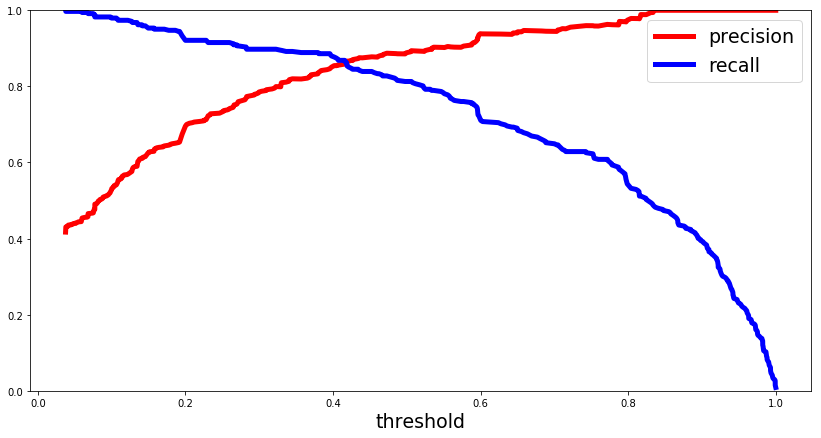

In [69]:
from sklearn.metrics import precision_recall_curve

# pegando as probabilidades de nossa predição
y_scores = random_forest.predict_proba(X_train)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(Y_train, y_scores)
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

#### Acima você pode ver claramente que o recall está caindo rapidamente com uma precisão de cerca de 85%. Por causa disso, você pode querer selecionar a troca de precision / recall antes disso - talvez em torno de 75%.

#### Agora você pode escolher um limite, que oferece a melhor compensação de precisão / recall para seu problema atual de machine learning. Se você quiser, por exemplo, uma precisão de 80%, pode ver facilmente os gráficos e ver que precisaria de um limite de cerca de 0,4. Então você poderia treinar um modelo com exatamente esse limiar e obteria a precisão desejada.

#### Outra maneira é traçar a precision / recall uns contra os outros:

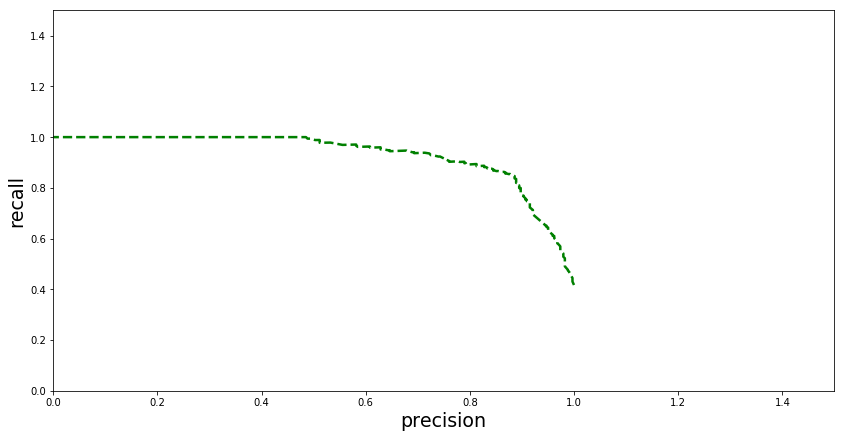

In [70]:
def plot_precision_vs_recall(precision, recall):
    plt.plot(recall, precision, "g--", linewidth=2.5)
    plt.ylabel("recall", fontsize=19)
    plt.xlabel("precision", fontsize=19)
    plt.axis([0, 1.5, 0, 1.5])

plt.figure(figsize=(14, 7))
plot_precision_vs_recall(precision, recall)
plt.show()

### Curva ROC AUC

#### Outra maneira de avaliar e comparar seu classificador binário é fornecida pela Curva ROC AUC. Esta curva representa a taxa positiva real (também chamada de recall) contra a taxa de falsos positivos (proporção de instâncias negativas incorretamente classificadas), em vez de traçar a precision x recall.

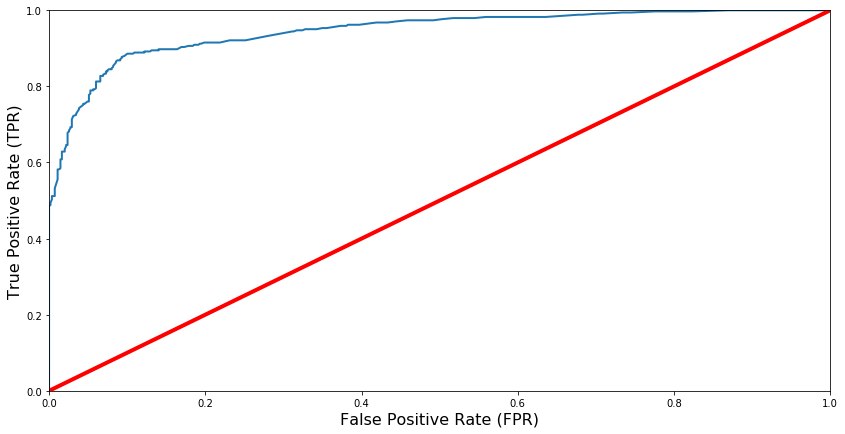

In [71]:
from sklearn.metrics import roc_curve
# computando  taxa de verdadeiro positivo e  taxa de falso positivo
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_train, y_scores)

# Coloando um contra o outro
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

#### A linha vermelha no meio representa um classificador puramente aleatório (por exemplo, um lançamento de moedas) e, portanto, seu classificador deve estar o mais longe possível. Nosso modelo Random Forest parece fazer um bom trabalho.

#### É claro que também temos uma desvantagem aqui, porque o classificador produz mais falsos positivos, quanto maior a taxa positiva verdadeira.

### ROC AUC Score

#### O ROC AUC Score é a pontuação correspondente à Curva ROC AUC. É calculado simplesmente medindo a área sob a curva, que é chamada de AUC.

#### Um classificador 100% correto teria uma pontuação AUC ROC de 1 e um classificador completamente aleatório teria uma pontuação de 0,5.

In [72]:
from sklearn.metrics import roc_auc_score
r_a_score = roc_auc_score(Y_train, y_scores)
print("ROC-AUC-Score:", r_a_score)

ROC-AUC-Score: 0.9450835650145398


#### Muito Bom! acredito que esse score é suficiente para conseguir uma boa pontuação no desafio do Kaggle.

## Resumo

### Começamos com a exploração de dados, onde percebemos o conjunto de dados, verificamos os dados ausentes e aprendemos quais recursos são importantes. Durante esse processo, usamos o seaborn e o matplotlib para fazer as visualizações.

###  Durante a parte de pré-processamento de dados, calculamos valores ausentes, convertemos recursos em valores numéricos, agrupamos valores em categorias e criamos algumas novas features.

### Depois disso, começamos a treinar 8 modelos diferentes de aprendizado de máquina, escolhemos um deles (Random Forest) e aplicamos validação cruzada nele. 

###  Em seguida,  ajustamos sua performace ao otimizar os valores com hiperparametrização. Por fim, analisamos a matriz de confusão e calculamos a precisão, o recall e o f-score dos modelos.